In [30]:
import mysql.connector
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import csv


conn = mysql.connector.connect(host = "localhost", password = "123456", user = "root")
mycursor = conn.cursor()

str_select_all_movieinformation = "SELECT * FROM `filmdata`.`movieinformation`;" 
mycursor.execute(str_select_all_movieinformation)
select_all_movieinformation = mycursor.fetchall() 

str_select_all_user_name_fake = "SELECT * FROM `filmdata`.`user_name_fake`;" 
mycursor.execute(str_select_all_user_name_fake)
select_all_user_name = mycursor.fetchall()

def rating_clean(rating):
    if "/" in rating:
        return int(rating.split("/")[0])
    return rating

data = {
    "user_name": [],
    "movie_id": [],
    "rating": []
}

csv_file_path = "output.csv"

In [11]:
with open(csv_file_path, mode='w', newline='') as file:
    # Khởi tạo đối tượng ghi CSV
    writer = csv.writer(file)
    
    writer.writerow(["user_name", "movie_id", "rating"])

    if select_all_user_name:
        for user_name in select_all_user_name:
            # user_name
            # print("User name: " + user_name[0])

            if select_all_movieinformation:
                for movieinformation in select_all_movieinformation:        
                    # print("Movie id: " + str(movieinformation[0]))      
                    data["user_name"].append(user_name[0])
                    data["movie_id"].append(movieinformation[0])

                    rating = False

                    # rating in film_review
                    str_select_film_review_movie_id = "SELECT * FROM `filmdata`.`film_review` WHERE `name_review` = '" + str(user_name[0]) + "' AND `movie_id` = '" + str(movieinformation[0]) + "' AND `star_review` != '10/10';"
                    mycursor.execute(str_select_film_review_movie_id)
                    select_film_review_movie_id = mycursor.fetchall()

                    if select_film_review_movie_id:
                        for film_review in select_film_review_movie_id:
                            rating = rating_clean(film_review[2])
                            data["rating"].append(rating_clean(film_review[2]))
                            # print("Rating: " + rating_clean(film_review[2]))

                    # rating in like_movie
                    str_select_like_movie_movie_id = "SELECT * FROM `filmdata`.`like_movie` WHERE `user_name` = '" + str(user_name[0]) + "' AND `movie_id` = '" + str(movieinformation[0]) + "';"
                    mycursor.execute(str_select_like_movie_movie_id)
                    select_like_movie_movie_id = mycursor.fetchall()

                    if select_like_movie_movie_id:
                        for like_movie in select_like_movie_movie_id:
                            rating = 10
                            data["rating"].append(10)

                    if not rating:
                        rating = 0
                        data["rating"].append(0)
                        # print("Rating: 0")

                    data_csv = {}

                    data_csv["user_name"] = user_name[0]
                    data_csv["movie_id"] = movieinformation[0]
                    data_csv["rating"] = rating

                    writer.writerow([data_csv["user_name"], data_csv["movie_id"], data_csv["rating"]])

            # print(data)


In [31]:
df_read = pd.read_csv("output.csv")

# Chọn các cột user_name, movie_id và rating
selected_columns = ["user_name", "movie_id", "rating"]
df = df_read[selected_columns]

# Hiển thị DataFrame
print(df.head())

      user_name  movie_id  rating
0  04GreatFlick         2       0
1  04GreatFlick         3       0
2  04GreatFlick         4       0
3  04GreatFlick         5       0
4  04GreatFlick         6      10


In [32]:
# Xem thông tin cơ bản của DataFrame
print(df.info())

# Xem các thống kê mô tả của dữ liệu
print(df.describe())

# Kiểm tra các giá trị thiếu
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362095 entries, 0 to 362094
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_name  362095 non-null  object
 1   movie_id   362095 non-null  int64 
 2   rating     362095 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ MB
None
            movie_id         rating
count  362095.000000  362095.000000
mean       71.000000       0.650752
std        40.124861       2.434201
min         2.000000       0.000000
25%        36.000000       0.000000
50%        71.000000       0.000000
75%       106.000000       0.000000
max       140.000000      10.000000
user_name    0
movie_id     0
rating       0
dtype: int64


          movie_id    rating
movie_id  1.000000  0.000441
rating    0.000441  1.000000


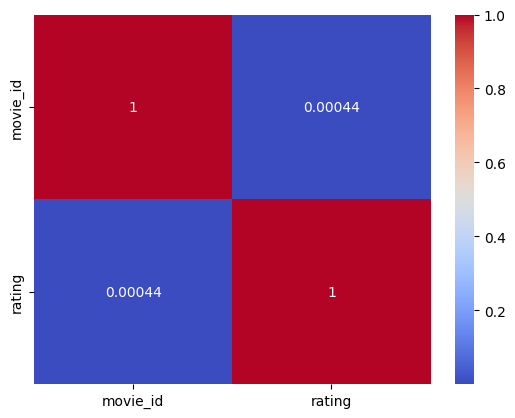

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Chọn các cột chỉ chứa dữ liệu số
df_numeric = df.select_dtypes(include=['int64', 'float64'])

# Tính toán ma trận tương quan
correlation_matrix = df_numeric.corr()
print(correlation_matrix)

# Vẽ biểu đồ tương quan
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [45]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

# Tạo Reader và Dataset từ DataFrame
reader = Reader(rating_scale=(1, 10))
dataset = Dataset.load_from_df(df[['user_name', 'movie_id', 'rating']], reader)

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
trainset, testset = train_test_split(dataset, test_size=0.2)

# Huấn luyện mô hình
model = SVD()
model.fit(trainset)

# Dự đoán và đánh giá mô hình
predictions = model.test(testset)
accuracy.rmse(predictions)


RMSE: 2.7939


2.7939493946342617

In [50]:
movie_id_list = df['movie_id'].unique()

user_name = "0rbita1"
movies_to_predict = [movie_id for movie_id in movie_id_list if movie_id not in df[df['user_name'] == user_name]['movie_id']]
predicted_ratings  = [model.predict(user_name, movie_id) for movie_id in movies_to_predict]


In [53]:
# Sắp xếp các đề xuất dựa trên điểm dự đoán (est)
recommended_movies = sorted(predicted_ratings, key=lambda x: x.est, reverse=True)[:10]
print("Top 10 recommended movies for user", user_name)
for movie in recommended_movies:
    print("Movie ID:", movie.iid, "| Estimated Rating:", round(movie.est, 2))

Top 10 recommended movies for user 0rbita1
Movie ID: 4 | Estimated Rating: 8.79
Movie ID: 89 | Estimated Rating: 8.78
Movie ID: 88 | Estimated Rating: 8.61
Movie ID: 107 | Estimated Rating: 8.06
Movie ID: 66 | Estimated Rating: 7.97
Movie ID: 62 | Estimated Rating: 7.81
Movie ID: 27 | Estimated Rating: 7.49
Movie ID: 137 | Estimated Rating: 7.45
Movie ID: 6 | Estimated Rating: 6.83
Movie ID: 65 | Estimated Rating: 5.46
